In [1]:
import torch, numpy as np, torch.backends.cudnn as cudnn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn import SmoothL1Loss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from model import EmbeddingBlock, FourierVectorize, FKAN, InverseFourier

cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(2025); np.random.seed(2025)
eps = 1e-6

X_T1.npy, Y_T1.npy 저장: (10911, 4, 288) (10911, 12)


In [2]:
X = np.load("X_T1.npy")
Y = np.load("Y_T1.npy")
X_mu, X_std = np.load("X_mean.npy"), np.load("X_std.npy")
Y_mu, Y_std = np.load("Y_mean.npy"), np.load("Y_std.npy")

Y_norm = (Y - Y_mu) / (Y_std + eps)
X_t = torch.tensor(X, dtype=torch.float32)
Y_t = torch.tensor(Y_norm, dtype=torch.float32)
ds = TensorDataset(X_t, Y_t)

tr_len = int(0.8 * len(ds))
train_ds, val_ds = random_split(ds, [tr_len, len(ds) - tr_len])
train_ld = DataLoader(train_ds, batch_size=64, shuffle=True,  pin_memory=True, num_workers=2)
val_ld = DataLoader(val_ds,   batch_size=64, shuffle=False, pin_memory=True, num_workers=2)

B, N, T = X.shape
τ = Y.shape[1]
D = 16
LOW_K = int(T * 0.10)
γ_dim = N * D * LOW_K * 2

X_mu_t = torch.tensor(X_mu,  dtype=torch.float32, device=DEVICE)
X_std_t = torch.tensor(X_std, dtype=torch.float32, device=DEVICE)
Y_mu_t = torch.tensor(Y_mu,  dtype=torch.float32, device=DEVICE)
Y_std_t = torch.tensor(Y_std, dtype=torch.float32, device=DEVICE)


In [3]:
from torch.amp import GradScaler
class SugarNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = EmbeddingBlock(D)
        self.fvec= FourierVectorize(T, k_bins=LOW_K, mode="ri")
        ψ_dim = self.fvec.output_dim(N, D)
        self.fkan = FKAN(ψ_dim, 128, γ_dim, G=5)
        self.inv = InverseFourier(N, D, τ, LOW_K)
    def forward(self, x_raw):
        h  = self.embed(x_raw)
        ψ  = self.fvec(h)
        γ  = self.fkan(ψ)
        return self.inv(γ)

model = SugarNet().to(DEVICE)
try:
    model.fkan.load_state_dict(torch.load("best_fkan.pt"), strict=False)
except:
    pass

opt= AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
sched = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=4)
crit= SmoothL1Loss()
scaler = GradScaler(enabled=(DEVICE.type=="cuda"))

best, wait, pat = 1e9, 0, 8

In [4]:
for ep in range(1, 81):
    model.train(); tr_loss=0; n=0
    for xb_raw, yb in train_ld:
        xb_raw, yb = xb_raw.to(DEVICE), yb.to(DEVICE)
        xb_norm = (xb_raw - X_mu_t) / (X_std_t + eps)
        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=DEVICE.type=="cuda"):
            pred = model(xb_norm)
            loss = crit(pred, yb)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        tr_loss += loss.item()*xb_raw.size(0); n += xb_raw.size(0)
    tr_loss /= n

    model.eval(); va_loss=0; m=0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=DEVICE.type=="cuda"):
        for xb_raw, yb in val_ld:
            xb_raw, yb = xb_raw.to(DEVICE), yb.to(DEVICE)
            xb_norm = (xb_raw - X_mu_t) / (X_std_t + eps)
            va_loss += crit(model(xb_norm), yb).item()*xb_raw.size(0)
            m += xb_raw.size(0)
    va_loss /= m
    sched.step(va_loss)

    print(f"[{ep:02d}] train={tr_loss:.4f}  val={va_loss:.4f}")
    if va_loss < best - 1e-4:
        best, wait = va_loss, 0
        torch.save(model.state_dict(), "best_sugarnet.pt")
    else:
        wait += 1
        if wait >= pat:
            break


/tmp/ipykernel_15732/3595982304.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=DEVICE.type=="cuda"):
/tmp/ipykernel_15732/3595982304.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=DEVICE.type=="cuda"):


[01] train=0.3656  val=0.3670
[02] train=0.3609  val=0.3644
[03] train=0.3589  val=0.3622
[04] train=0.3582  val=0.3610
[05] train=0.3570  val=0.3609
[06] train=0.3572  val=0.3605
[07] train=0.3562  val=0.3603
[08] train=0.3556  val=0.3603
[09] train=0.3555  val=0.3591
[10] train=0.3549  val=0.3596
[11] train=0.3544  val=0.3589
[12] train=0.3539  val=0.3570
[13] train=0.3534  val=0.3570
[14] train=0.3528  val=0.3580
[15] train=0.3531  val=0.3566
[16] train=0.3524  val=0.3580
[17] train=0.3513  val=0.3557
[18] train=0.3509  val=0.3569
[19] train=0.3508  val=0.3562
[20] train=0.3501  val=0.3555
[21] train=0.3502  val=0.3548
[22] train=0.3492  val=0.3558
[23] train=0.3486  val=0.3557
[24] train=0.3484  val=0.3561
[25] train=0.3478  val=0.3552
[26] train=0.3470  val=0.3539
[27] train=0.3462  val=0.3539
[28] train=0.3464  val=0.3529
[29] train=0.3452  val=0.3524
[30] train=0.3451  val=0.3552
[31] train=0.3450  val=0.3539
[32] train=0.3442  val=0.3562
[33] train=0.3433  val=0.3536
[34] train

In [ ]:
model.load_state_dict(torch.load("best_sugarnet.pt", map_location=DEVICE))
model.eval()
with torch.no_grad():
    X_raw_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    X_norm  = (X_raw_t - X_mu_t) / (X_std_t + eps)
    Δ_norm  = model(X_norm)
    Δ       = Δ_norm * Y_std_t + Y_mu_t
    last_raw = X_raw_t[:,0,-1]
    if X_std_t.ndim == 0:
        last = last_raw * X_std_t + X_mu_t
    else:
        last = last_raw * X_std_t[0,-1] + X_mu_t[0,-1]
    pred = (last.unsqueeze(1) + Δ).cpu().numpy()
    true = Y + last.cpu().unsqueeze(1).numpy()

rmse = np.sqrt(((pred-true)**2).mean())
mask = true != 0
mard = (np.abs((pred[mask]-true[mask])/true[mask]).mean()*100)
tir  = np.mean((pred>=70)&(pred<=180))*100
print(f"RMSE {rmse:.2f} mg/dL | MARD {mard:.2f}% | TIR {tir:.2f}%")

In [5]:
import torch, numpy as np
from model import SugarNet
from Shanghai_Datasets import FUTURE_LEN

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 1e-6

X = np.load('X_T1.npy')
Y = np.load('Y_T1.npy')
X_mu= np.load('X_mean.npy')
X_std = np.load('X_std.npy')
Y_mu= np.load('Y_mean.npy')
Y_std  = np.load('Y_std.npy')

n_test = int(len(X) * 0.20)
X_te= X[-n_test:]
Y_te = Y[-n_test:]

X_mu_t = torch.tensor(X_mu, dtype=torch.float32, device=DEVICE)
X_std_t = torch.tensor(X_std, dtype=torch.float32, device=DEVICE)
Y_mu_t= torch.tensor(Y_mu, dtype=torch.float32, device=DEVICE)
Y_std_t = torch.tensor(Y_std, dtype=torch.float32, device=DEVICE)

model = SugarNet(H=128).to(DEVICE)
model.load_state_dict(torch.load('best_sugarnet.pt', map_location=DEVICE))
model.eval()

with torch.no_grad():
    x_raw = torch.tensor(X_te, dtype=torch.float32, device=DEVICE)
    x_n = (x_raw - X_mu_t) / (X_std_t + eps)
    d_n = model(x_n)
    d = d_n * Y_std_t + Y_mu_t
    last = x_raw[:,0,-1] * X_std_t + X_mu_t
    pred = (last.unsqueeze(1) + d).cpu().numpy()
    true = Y_te + last.cpu().unsqueeze(1).numpy()

rmse = np.sqrt(((pred - true) ** 2).mean(axis=0))
mard = (np.abs((pred - true) / true).mean(axis=0)) * 100

def ceg(y, yh):
    z = np.zeros_like(y, dtype=np.int8)
    a = (np.abs(yh - y) / y <= 0.2) | ((y < 70) & (yh < 70))
    z[a] = 1
    b = (z == 0) & (np.abs(yh - y) <= 110)
    z[b] = 2
    z[z == 0] = 3
    return z

zones = ceg(true.flatten(), pred.flatten())
za = (zones == 1).mean() * 100
zb = (zones == 2).mean() * 100

for h, r, m in zip([30, 60, 90, 120], rmse, mard):
    print(f'{h}min\tRMSE {r:.2f} mg/dL\tMARD {m:.2f}%')
print(f'ZoneA {za:.2f}% | ZoneB {zb:.2f}% | A+B {(za+zb):.2f}%')


30min	RMSE 13.25 mg/dL	MARD 5.85%
60min	RMSE 24.21 mg/dL	MARD 10.74%
90min	RMSE 34.04 mg/dL	MARD 15.30%
120min	RMSE 43.05 mg/dL	MARD 19.66%
ZoneA 64.23% | ZoneB 26.01% | A+B 90.23%


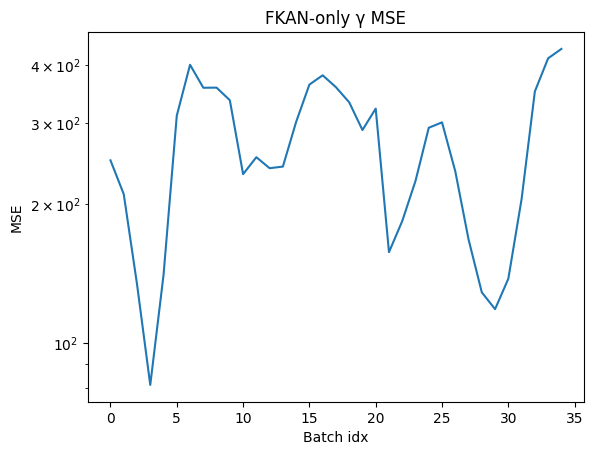

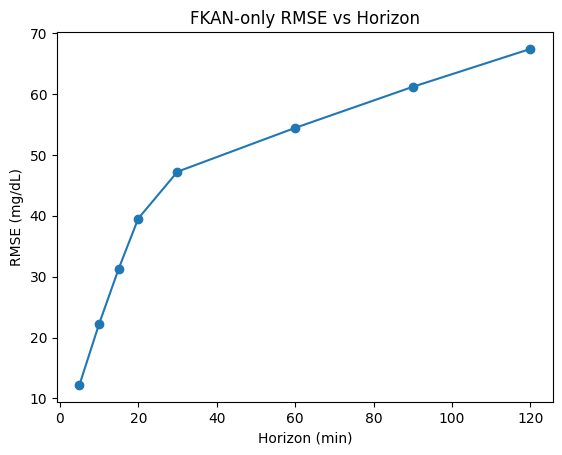

In [6]:
# 이 코드는, fkan을 평가하고 ...



import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import DataLoader, TensorDataset

from model import SugarNet
from Shanghai_Datasets import PAST_LEN, FUTURE_LEN

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = np.load("X_T1.npy").astype(np.float32)    
Y = np.load("Y_T1.npy").astype(np.float32)    
Y_mu = np.load("Y_mean.npy").astype(np.float32)
Y_std= np.load("Y_std.npy").astype(np.float32)

Yn = (Y - Y_mu)/(Y_std + 1e-6)
Yt = torch.from_numpy(Yn).float()

n_val = int(len(Yt)*0.2)
Xv = torch.from_numpy(X[-n_val:]).float()
Yv = Yt[-n_val:].float()

loader = DataLoader(TensorDataset(Xv,Yv),
                    batch_size=64, shuffle=False,
                    num_workers=0)

net = SugarNet(N=4, D=16, H=128, G=5).to(DEVICE)
net.load_state_dict(torch.load("best_sugarnet.pt", map_location=DEVICE))
net.eval()

Y_mu_t = torch.from_numpy(Y_mu).to(DEVICE)
Y_std_t= torch.from_numpy(Y_std).to(DEVICE)

LOW_K = int(PAST_LEN*0.10)

gamma_mse = []
rmse_h    = defaultdict(list)

with torch.no_grad():
    for xb_cpu, yb_cpu in loader:
        xb, yb_norm = xb_cpu.to(DEVICE), yb_cpu.to(DEVICE)

        H = net.embed(xb)
        psi = net.fvec(H)
        gamma_p  = net.fkan(psi)

        # gamma_true = psi (FKAN target is the DFT features)
        gamma_mse.append(((gamma_p - psi)**2).mean().item())

        Yp_norm = net.inv(gamma_p)
        Yp = Yp_norm * (Y_std_t + 1e-6) + Y_mu_t
        Yt_orig = yb_norm * (Y_std_t + 1e-6) + Y_mu_t

        for k, h in enumerate([5,10,15,20,30,60,90,120]):
            rmse_h[h].append(torch.sqrt(((Yp[:,k]-Yt_orig[:,k])**2).mean()).item())

plt.figure()
plt.semilogy(gamma_mse)
plt.title("FKAN-only γ MSE")
plt.xlabel("Batch idx")
plt.ylabel("MSE")
plt.show()

hs = sorted(rmse_h)
plt.figure()
plt.plot(hs, [np.mean(rmse_h[h]) for h in hs], "o-")
plt.title("FKAN-only RMSE vs Horizon")
plt.xlabel("Horizon (min)")
plt.ylabel("RMSE (mg/dL)")
plt.show()


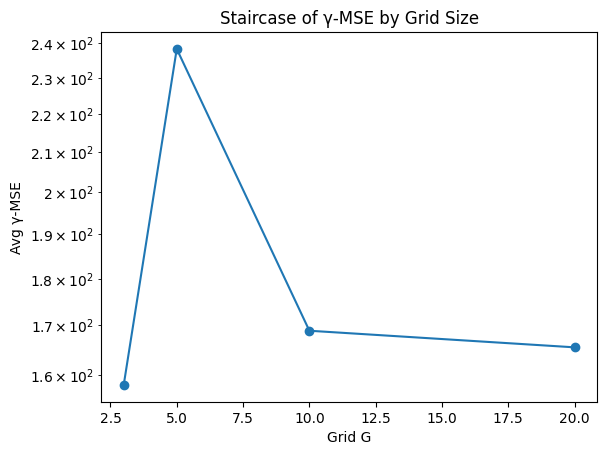

In [10]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from model import SugarNet
from Shanghai_Datasets import PAST_LEN

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = np.load('X_T1.npy').astype(np.float32)[-2000:]
Y = np.load('Y_T1.npy').astype(np.float32)[-2000:]
Y_mu = np.load('Y_mean.npy')
Y_std = np.load('Y_std.npy')
Yn = (Y - Y_mu) / (Y_std + 1e-6)
Yt = torch.from_numpy(Yn).float()

loader = DataLoader(
    TensorDataset(torch.from_numpy(X).float(), Yt),
    batch_size=64, shuffle=False, num_workers=0
)

net = SugarNet(N=4, D=16, H=128, G=5).to(DEVICE)
net.load_state_dict(torch.load('best_sugarnet.pt', map_location=DEVICE))
net.eval()

LOW_K = int(PAST_LEN * 0.10)
gamma_mse = []

with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(DEVICE)
        H = net.embed(xb)
        psi = net.fvec(H)
        gp = net.fkan(psi)

        H_resh = H.permute(0, 1, 3, 2).reshape(H.size(0), -1, PAST_LEN)
        fft = torch.fft.rfft(H_resh, n=PAST_LEN, dim=2)
        ri = torch.view_as_real(fft)[:, :, 1:LOW_K+1, :]
        gt = ri.reshape(ri.size(0), -1)

        gamma_mse.append(((gp - gt) ** 2).mean().item())

batch_per_G = len(gamma_mse) // 4
means = [
    np.mean(gamma_mse[i*batch_per_G:(i+1)*batch_per_G])
    for i in range(4)
]
Gs = [3, 5, 10, 20]

plt.figure()
plt.plot(Gs, means, 'o-')
plt.yscale('log')
plt.xlabel('Grid G')
plt.ylabel('Avg γ-MSE')
plt.title('Staircase of γ-MSE by Grid Size')
plt.show()


In [2]:
import time
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from model import EmbeddingBlock, FourierVectorize, FKAN
from Shanghai_Datasets import PAST_LEN

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = np.load('X_T1.npy').astype(np.float32)[:2000]
Y = np.load('Y_T1.npy').astype(np.float32)[:2000]
Y_mu, Y_std = np.load('Y_mean.npy'), np.load('Y_std.npy')
Yn = (Y - Y_mu) / (Y_std + 1e-6)

X_t = torch.from_numpy(X).float()
Y_t = torch.from_numpy(Yn).float()
ds = TensorDataset(X_t, Y_t)
tr_ds, vl_ds = random_split(ds, [1000, 1000])

tr_loader = DataLoader(tr_ds, batch_size=32, shuffle=True, num_workers=0)
vl_loader = DataLoader(vl_ds, batch_size=32, shuffle=False, num_workers=0)

N, D = 4, 16
LOW_K = int(PAST_LEN * 0.10)
embed = EmbeddingBlock(D).to(DEVICE)
fvec = FourierVectorize(PAST_LEN, k_bins=LOW_K, mode='ri').to(DEVICE)
in_dim = fvec.output_dim(N, D)
out_dim = in_dim

fkan = FKAN(in_dim, 64, out_dim, G=5).to(DEVICE)
mlp  = torch.nn.Sequential(
    torch.nn.Linear(in_dim,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,out_dim)
).to(DEVICE)

opt_k = torch.optim.Adam(fkan.parameters(), lr=1e-3)
opt_m = torch.optim.Adam(mlp.parameters(),  lr=1e-3)
crit  = torch.nn.MSELoss()

def make_gamma_true_all(loader):
    all_gt = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            H  = embed(xb)
            H2 = H.permute(0,1,3,2).reshape(H.size(0), -1, PAST_LEN)
            F = torch.fft.rfft(H2, n=PAST_LEN, dim=2)
            R = torch.view_as_real(F)[:, :, 1:LOW_K+1, :]
            all_gt.append(R.reshape(R.size(0), -1).cpu())
    return torch.cat(all_gt, dim=0)

gt_tr = make_gamma_true_all(tr_loader)
gt_vl = make_gamma_true_all(vl_loader)

for epoch in range(1, 6):
    start = time.time()
    fkan.train(); mlp.train()
    tr_k = tr_m = 0.0
    for i, (xb, _) in enumerate(tr_loader):
        xb = xb.to(DEVICE)
        gt = gt_tr[i*32:(i*32+xb.size(0))].to(DEVICE)

        psi = fvec(embed(xb))

        opt_k.zero_grad()
        predk = fkan(psi)
        lossk = crit(predk, gt)
        lossk.backward()
        opt_k.step()
        tr_k += lossk.item() * xb.size(0)

        psi_m = psi.detach()
        opt_m.zero_grad()
        predm = mlp(psi_m)
        lossm = crit(predm, gt)
        lossm.backward()
        opt_m.step()
        tr_m += lossm.item() * xb.size(0)

    tr_k /= len(tr_ds); tr_m /= len(tr_ds)

    fkan.eval(); mlp.eval()
    vl_k = vl_m = 0.0
    with torch.no_grad():
        for i, (xb, _) in enumerate(vl_loader):
            xb = xb.to(DEVICE)
            gt = gt_vl[i*32:(i*32+xb.size(0))].to(DEVICE)
            psi = fvec(embed(xb))
            vl_k += crit(fkan(psi), gt).item() * xb.size(0)
            vl_m += crit(mlp(psi), gt).item() * xb.size(0)
    vl_k /= len(vl_ds); vl_m /= len(vl_ds)

    print(f"Epoch {epoch} | FKAN tr {tr_k:.4f} vl {vl_k:.4f} | "
          f"MLP tr {tr_m:.4f} vl {vl_m:.4f} | {time.time()-start:.1f}s", flush=True)


Epoch 1 | FKAN tr 104.8963 vl 105.6186 | MLP tr 106.7226 vl 106.5112 | 204.1s
Epoch 2 | FKAN tr 104.8943 vl 105.6181 | MLP tr 105.4238 vl 106.4093 | 204.5s
Epoch 3 | FKAN tr 104.8925 vl 105.6176 | MLP tr 105.4015 vl 106.4933 | 204.3s
Epoch 4 | FKAN tr 104.8908 vl 105.6171 | MLP tr 105.4044 vl 106.1803 | 203.6s
Epoch 5 | FKAN tr 104.8891 vl 105.6167 | MLP tr 105.3122 vl 106.8974 | 204.7s
